In [1]:
import torch
import kornia
import cv2
import numpy as np
import pickle
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import kornia.feature as K
from kornia.feature import *
import torchvision

In [86]:
device = torch.device('cpu')
datatype = torch.float16
def get_camera_mat(file):
    tree = ET.parse(file)
    root = tree.getroot()
    for x in  root.iter("Camera_Matrix"):
        for y in x.iter("data"):
            camera_mat = np.matrix(y.text)
    for x in  root.iter("Distortion_Coefficients"):
        for y in x.iter("data"):
            distort_mat = np.matrix(y.text)
    camera_mat = np.asarray(camera_mat.reshape((3,3)))
    distort_mat = np.asarray(distort_mat)
    #print(camera_mat, distort_mat)
    return torch.tensor(camera_mat, dtype=datatype, device=device), torch.tensor(distort_mat,dtype=datatype, device=device)

def tensor_sift(img1, img2):
    img1 = kornia.image_to_tensor(img1).float().unsqueeze(0).to(device)
    img2 = kornia.image_to_tensor(img2).float().unsqueeze(0).to(device)
    #f img1.shape()
    sift = kornia.feature.SIFTDescriptor(512, rootsift=True).to(device)
    descriptor = sift

    resp = BlobHessian()
    #scale_pyr = kornia.geometry.ScalePyramid(3, 1.6, 512, double_image=True)
    nms = kornia.geometry.ConvQuadInterp3d(10)
    n_features = 2000
    detector = ScaleSpaceDetector(n_features,
                                resp_module=resp,
                                mr_size=6.0).to(device)

    with torch.no_grad():
        lafs, resps = detector(torch.cat([img1, img2]))
        patches =  kornia.feature.extract_patches_from_pyramid(torch.cat([img1, img2]), lafs, 512)
        B, N, CH, H, W = patches.size()
        # Descriptor accepts standard tensor [B, CH, H, W], while patches are [B, N, CH, H, W] shape
        # So we need to reshape a bit :)
        descs = descriptor(patches.view(B * N, CH, H, W)).view(B, N, -1)
        scores, matches = kornia.feature.match_snn(descs[0], descs[1], 0.9)#matches = Indexes of [desc1, desc2]

    # Now RANSACscores, matches
    src_pts = lafs[0,matches[:,0], :, 2]#.data.cpu().numpy()
    dst_pts = lafs[1,matches[:,1], :, 2]#.data.cpu().numpy()
    #F = kornia.geometry.epipolar.find_fundamental(src_pts, dst_pts)
    print(src_pts.shape)
    #H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 1.0, 0.999, 10000)
    #inliers = matches[torch.from_numpy(mask).bool().squeeze(), :]
    return src_pts, dst_pts
    # desc1 = sift(img1)
    # desc2 = sift(img2)
    # print(desc1.shape)
    # dist_matrix = torch.cdist(desc1,desc2)
    # top_k = 2
    # _, topk_indices = torch.topk(dist_matrix, k=top_k, dim=-1, largest=False, sorted=True)
    # lowe_ratio = 0.7
    # matches = torch.empty(0)
    # for i in range(desc1.shape[0]):
    #     dist1, dist2 = dist_matrix[i, topk_indices[i]]
    #     if dist1 < lowe_ratio * dist2:
    #         #matches.append([i, topk_indices[i, 0].item()])
    #         torch.cat((matches, torch.tensor([i, topk_indices[i, 0].item()])))
    # return matches


In [87]:
calib_file = "/home/turin/Desktop/lizard_dataset_curated/opencv_cam_calib.xml"
cam_K, cam_D = get_camera_mat(calib_file)

In [88]:
k = torch.empty(0)
torch.cat((k,torch.tensor([5])))

tensor([5.])

In [ ]:
img_path = "/home/turin/Desktop/lizard_island/jackson/chronological/2014/r20141102_074952_lizard_d2_081_horseshoe_circle01/081_photos/"
file = open("/home/turin/Documents/GitHub/long_term_underwater_vision/dataset/dataset_positive", 'rb')
im, label = pickle.load(file)
file.close()
idx = 0
img1 = img_path + im[idx][0]
img2 = img_path + im[idx][1]
img2 = "/home/turin/Desktop/lizard_island/jackson/chronological/2015/r20151207_222558_lizard_d2_039_horseshoe_circle01/039_photos/PR_20151207_222624_239_LC16.png"
print(img1, img2)
mat1 = label[idx][1][0]
mat2 = label[idx][1][1]
img1 = cv2.imread(img1)
img2 = cv2.imread(img2)
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
print(gray1.shape)
# gray1_reduced = cv2.resize(gray1, (680, 512))
# gray2_reduced = cv2.resize(gray2, (680, 512))
# clip_im = int(.5*(gray2_reduced.shape[1] - gray2_reduced.shape[0]))
# gray1_clipped = gray1_reduced[:,clip_im:gray1_reduced.shape[0]+clip_im]
# gray2_clipped = gray2_reduced[:,clip_im:gray1_reduced.shape[0]+clip_im]
matches = tensor_sift(gray1, gray2)

/home/turin/Desktop/lizard_island/jackson/chronological/2014/r20141102_074952_lizard_d2_081_horseshoe_circle01/081_photos/PR_20141102_074954_230_LC16.png /home/turin/Desktop/lizard_island/jackson/chronological/2015/r20151207_222558_lizard_d2_039_horseshoe_circle01/039_photos/PR_20151207_222624_239_LC16.png
(1024, 1360)


In [ ]:
matches

torch.Size([1, 1, 1024, 1360])
torch.Size([512, 680])


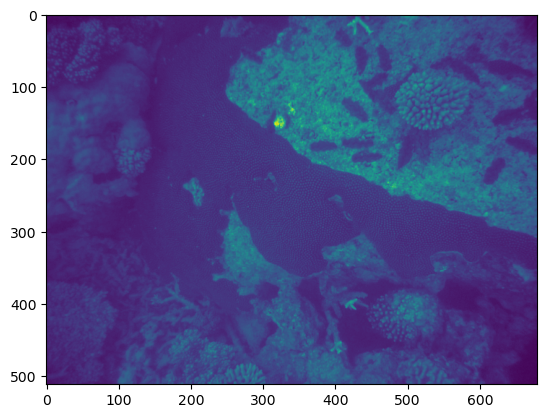

In [82]:
im_t =  torch.from_numpy(gray1)
gray1_t = im_t.unsqueeze(0)
gray1_t = gray1_t.unsqueeze(0)
print(gray1_t.shape)
#plt.imshow(im_t.data.cpu().numpy())
gray1_reduced = torchvision.transforms.functional.resize(gray1_t, [512, 680])
aaa = gray1_reduced.squeeze(0).squeeze(0)
print(aaa.shape)
plt.imshow(aaa.data.cpu().numpy())

In [83]:
matches[1]
# # match_idx = []
# # for itr in range(len(matches[0])):
# #     for itd in range(len(matches[2])):
# #         if matches[0][itr] == matches[2][itd]:
# #             match_idx.append(itr)
# # matches[0][20], matches[2][90]

tensor([[832., 640.],
        [392.,   0.],
        [392.,   0.],
        [832., 640.],
        [832., 640.],
        [832., 640.],
        [392.,   0.],
        [392.,   0.]])

In [84]:
match = matches
kp1 = match[0].data.cpu().numpy().astype(int)
kp2 = match[1].data.cpu().numpy().astype(int)
#inl = match[1]#.astype(int)
img3 = np.hstack((gray1, gray2))
# img3 = np.hstack((gray1_clipped, gray2_clipped))
# plt.imshow(img3)

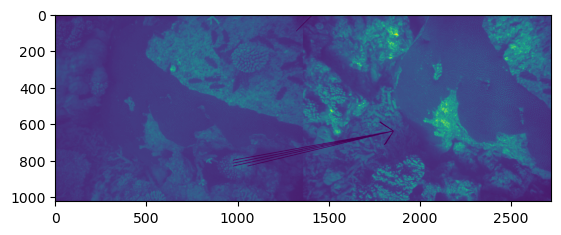

In [85]:
pts1 = kp1
pts2 = kp2
pts2[:,0] = kp2[:, 0]+1024
img6 = 0
img3 = 0
img3 = np.hstack((gray1, gray2))
for x in range(len(kp1)):
    img6 = cv2.arrowedLine(img3, pts1[x], pts2[x], (0, 0, 255), 3)
plt.imshow(img6)

In [ ]:
def vis_k_sift(img1, img2, match):
    img_matched = 0
    img_stacked = 0
    kp1 = match[0].data.cpu().numpy().astype(int)
    kp2 = match[1].data.cpu().numpy().astype(int)
    pts1 = kp1
    pts2 = kp2
    pts2[:,0] = kp2[:, 0]+1024
    img_stacked = np.hstack((img1, img2))
    for x in range(len(kp1)):
        img_matched = cv2.arrowedLine(img_stacked, pts1[x], pts2[x], (0, 0, 255), 3)
    plt.imshow(img_matched)

In [10]:
vis_k_sift(gray1, gray2, matches)

NameError: name 'vis_k_sift' is not defined

In [7]:
from torchvision import transforms
#gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
#gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
#gray2 = cv2.flip(gray2, 0)
transform = transforms.Compose([transforms.ToTensor(), transforms.ConvertImageDtype(torch.float32), transforms.Resize(size=(1360,1024), interpolation=transforms.InterpolationMode("nearest"))])
img_path = "/home/turin/Desktop/lizard_island/jackson/chronological/2014/r20141102_074952_lizard_d2_081_horseshoe_circle01/081_photos/"
file = open("/home/turin/Documents/GitHub/long_term_underwater_vision/dataset/dataset_positive", 'rb')
im, label = pickle.load(file)
file.close()
idx = 0
img1 = img_path + im[idx][0]
img2 = img_path + im[idx][1]
img2 = "/home/turin/Desktop/lizard_island/jackson/chronological/2015/r20151207_222558_lizard_d2_039_horseshoe_circle01/039_photos/PR_20151207_222624_239_LC16.png"
print(img1, img2)
mat1 = label[idx][1][0]
mat2 = label[idx][1][1]
img1 = cv2.imread(img1)
img2 = cv2.imread(img2)
# gray1 = img1
# gray2 = img2
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
gray1 = transform(gray1).unsqueeze(0)
gray2 = transform(gray2).unsqueeze(0)
# detector = kornia.feature.KeyNetDetector(pretrained=True, num_features=100, ori_module=None, aff_module=None)
# lafs1,_ = detector(gray1)
# lafs2,_ = detector(gray2)
# patch1 =  kornia.feature.extract_patches_from_pyramid(gray1, lafs1, 32)
# patch2 =  kornia.feature.extract_patches_from_pyramid(gray2, lafs2, 32)
# detector = ScaleSpaceDetector(100)
# with torch.no_grad():
#         lafs, resps = detector(torch.cat([gray1, gray2]))
#         lafs
#         #patches =  kornia.feature.extract_patches_from_pyramid(torch.cat([img1, img2]), lafs, 512)
#         #B, N, CH, H, W = patches.size()
#         # Descriptor accepts standard tensor [B, CH, H, W], while patches are [B, N, CH, H, W] shape
#         # So we need to reshape a bit :)
#         #descs = descriptor(patches.view(B * N, CH, H, W)).view(B, N, -1)
#         #print(descs.shape)
#         #scores, matches = kornia.feature.match_snn(descs[0], descs[1], 0.9)
# #
# #desc1 = sift(img1)

/home/turin/Desktop/lizard_island/jackson/chronological/2014/r20141102_074952_lizard_d2_081_horseshoe_circle01/081_photos/PR_20141102_074954_230_LC16.png /home/turin/Desktop/lizard_island/jackson/chronological/2015/r20151207_222558_lizard_d2_039_horseshoe_circle01/039_photos/PR_20151207_222624_239_LC16.png


In [34]:
detector = kornia.feature.ScaleSpaceDetector(num_features=50)
det1,_ = detector(gray1)
det2,_ = detector(gray2)
patch1 =  kornia.feature.extract_patches_from_pyramid(gray1, det1, 32)
patch2 =  kornia.feature.extract_patches_from_pyramid(gray2, det2, 32)
# descriptor = kornia.feature.SIFTDescriptor(patch_size=32, num_ang_bins=8, num_spatial_bins=4, rootsift=True, clipval=0.2)
# desc1 = descriptor(patch1)
# desc2 = descriptor(patch2)

tensor([[[ 54.3066,   0.0000, 485.9994],
         [  0.0000,  54.3066, 403.9995]]])

In [60]:
B, N, CH, H, W = patch1.size()
pt1 = patch1.view(B * N, CH, H, W)
pt2 = patch2.view(B * N, CH, H, W)
descriptor = kornia.feature.SIFTDescriptor(patch_size=32, num_ang_bins=8, num_spatial_bins=4, rootsift=True, clipval=0.2)
desc1 = descriptor(pt1)
desc2 = descriptor(pt2)
#desc1 = desc1.view(B, N, -1)
#desc2 = desc2.view(B, N, -1)
scores, matches = kornia.feature.match_snn(desc1, desc2, th=1.15, dm=None)
det1[0][0][:,2], det2[0][49][:,2]
# src_pts = det1[matches[:,0], :, 2]#.data.cpu().numpy()
#dst_pts = lafs[1,matches[:,1], :, 2]

(tensor([485.9995, 402.0004]), tensor([143.9998, 858.0002]))

In [72]:
det1

tensor([[[[ 54.3079,   0.0000, 485.9995],
          [  0.0000,  54.3079, 402.0004]],

         [[ 54.3066,   0.0000, 485.9994],
          [  0.0000,  54.3066, 403.9995]],

         [[ 54.3066,   0.0000, 484.0007],
          [  0.0000,  54.3066, 402.0004]],

         [[ 54.3056,   0.0000, 484.0007],
          [  0.0000,  54.3056, 403.9995]],

         [[ 54.3095,   0.0000, 485.9995],
          [  0.0000,  54.3095, 400.0011]],

         [[ 54.3081,   0.0000, 484.0007],
          [  0.0000,  54.3081, 400.0012]],

         [[ 48.3876,   0.0000, 484.0002],
          [  0.0000,  48.3876, 403.9997]],

         [[ 54.3059,   0.0000, 485.9994],
          [  0.0000,  54.3059, 405.9986]],

         [[ 54.3052,   0.0000, 484.0007],
          [  0.0000,  54.3052, 405.9987]],

         [[ 54.3088,   0.0000, 487.9984],
          [  0.0000,  54.3088, 402.0003]],

         [[ 48.3897,   0.0000, 484.0002],
          [  0.0000,  48.3897, 402.0006]],

         [[ 54.3074,   0.0000, 487.9983],
          [ 

In [71]:
det2[:, matches[:,1],:,2]

tensor([[[143.9998, 858.0002],
         [143.9998, 858.0002],
         [143.9998, 858.0002],
         [143.9998, 858.0002],
         [143.9998, 858.0002],
         [143.9998, 858.0002],
         [384.0014, 149.9991],
         [143.9998, 858.0002],
         [143.9998, 858.0002],
         [143.9998, 858.0002],
         [384.0014, 149.9991],
         [143.9998, 858.0002],
         [143.9998, 858.0002],
         [143.9998, 858.0002],
         [384.0018, 149.9988],
         [384.0018, 149.9988],
         [143.9998, 858.0002],
         [384.0014, 149.9991],
         [384.0018, 149.9988],
         [384.0018, 148.0009],
         [143.9998, 858.0002],
         [143.9998, 858.0002],
         [143.9998, 858.0002],
         [384.0018, 148.0009],
         [143.9998, 858.0002],
         [143.9998, 858.0002],
         [384.0018, 149.9988],
         [143.9998, 858.0002],
         [143.9998, 858.0002],
         [143.9998, 858.0002],
         [384.0014, 149.9991],
         [384.0014, 149.9991],
        

In [ ]:
loftr = kornia.feature.LoFTR(pretrained='outdoor')

input = {"image0": gray1, "image1": gray2}
out = loftr(input)

Downloading: "http://cmp.felk.cvut.cz/~mishkdmy/models/loftr_outdoor.ckpt" to /home/turin/.cache/torch/hub/checkpoints/loftr_outdoor.ckpt


  0%|          | 0.00/44.2M [00:00<?, ?B/s]

In [78]:
out

{'keypoints0': tensor([], size=(0, 2)),
 'keypoints1': tensor([], size=(0, 2)),
 'lafs0': tensor([], size=(0, 0, 2, 3)),
 'lafs1': tensor([], size=(0, 0, 2, 3)),
 'confidence': tensor([]),
 'batch_indexes': tensor([], dtype=torch.int64)}